In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import keras
from keras import layers
from keras.models import Sequential


In [4]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


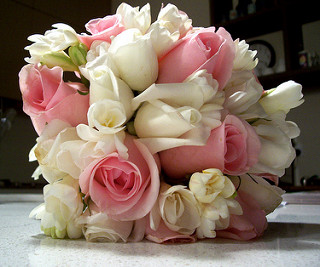

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

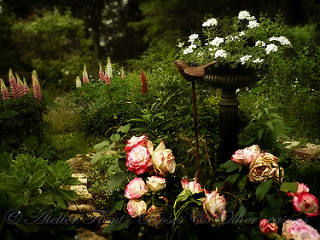

In [7]:
PIL.Image.open(str(roses[1]))

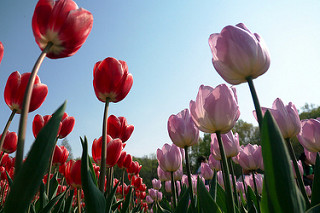

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


In [9]:
batch_size = 32
img_height = 180
img_width = 180


In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-07-01 09:44:47.604436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 09:44:48.011283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 09:44:48.015548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-07-01 09:47:50.748806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


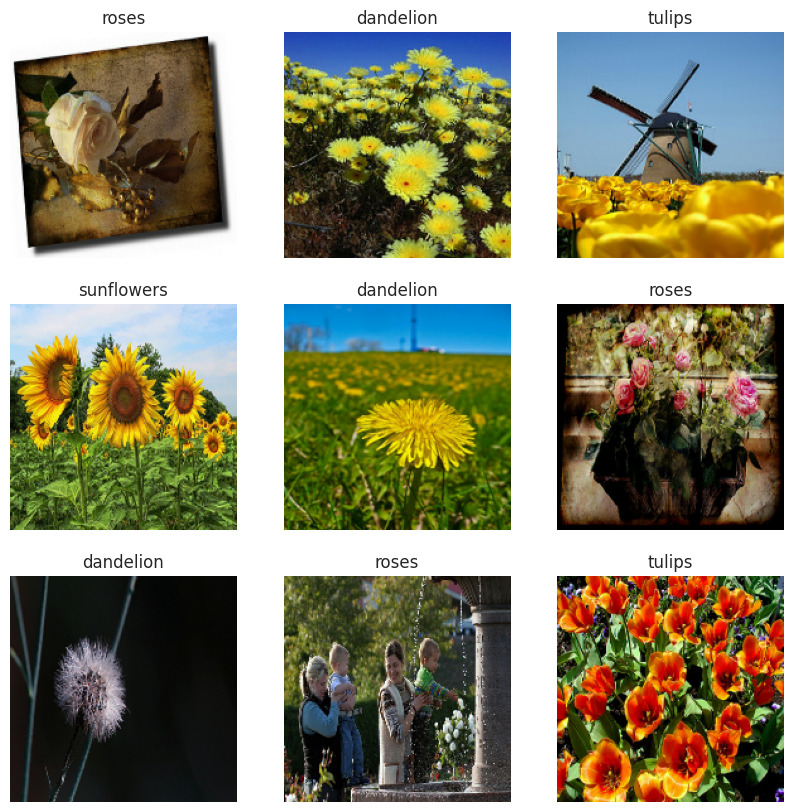

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255), 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3170 - loss: 1.6517 - val_accuracy: 0.5218 - val_loss: 1.1464
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5667 - loss: 1.0567 - val_accuracy: 0.6349 - val_loss: 0.9772
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6871 - loss: 0.8589 - val_accuracy: 0.6185 - val_loss: 0.9502
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7476 - loss: 0.6817 - val_accuracy: 0.6444 - val_loss: 0.8686
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8443 - loss: 0.4580 - val_accuracy: 0.6308 - val_loss: 0.9560
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9021 - loss: 0.3039 - val_accuracy: 0.6567 - val_loss: 1.0980
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9523 - loss: 0.1522 - val_accuracy: 0.6444 - val_loss: 1.3603
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9791 - loss: 0.0916 - val_accuracy: 0.6376 - val_loss

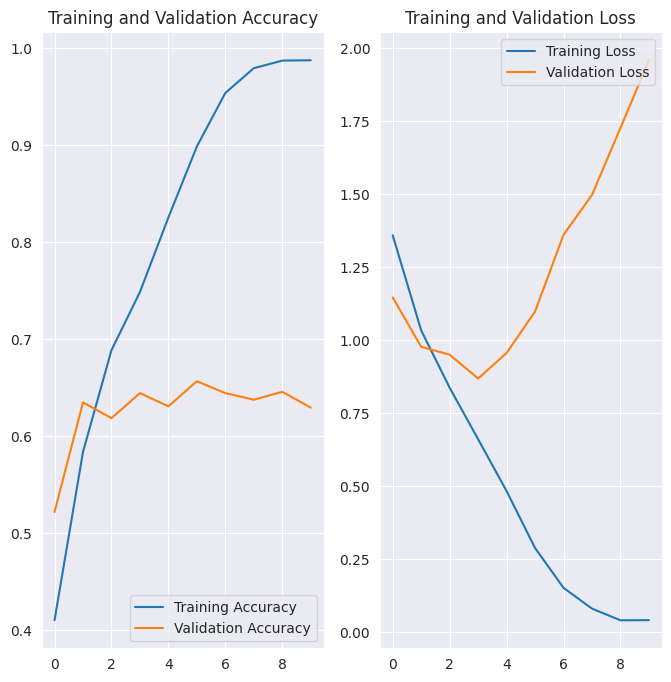

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [31]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [33]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15


2024-07-01 09:52:36.020905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3578 - loss: 1.5960 - val_accuracy: 0.5804 - val_loss: 1.0669
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5790 - loss: 1.0671 - val_accuracy: 0.5722 - val_loss: 1.1041
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6380 - loss: 0.9254 - val_accuracy: 0.6526 - val_loss: 0.8890
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6566 - loss: 0.8620 - val_accuracy: 0.6785 - val_loss: 0.8321
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6952 - loss: 0.8116 - val_accuracy: 0.6948 - val_loss: 0.8272
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7234 - loss: 0.7374 - val_accuracy: 0.7180 - val_loss: 0.7473
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7075 - loss: 0.7545 - val_accuracy: 0.6921 - val_loss: 0.7847
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7335 - loss: 0.7092 - val_accuracy: 0.7057 - val_loss: 0.

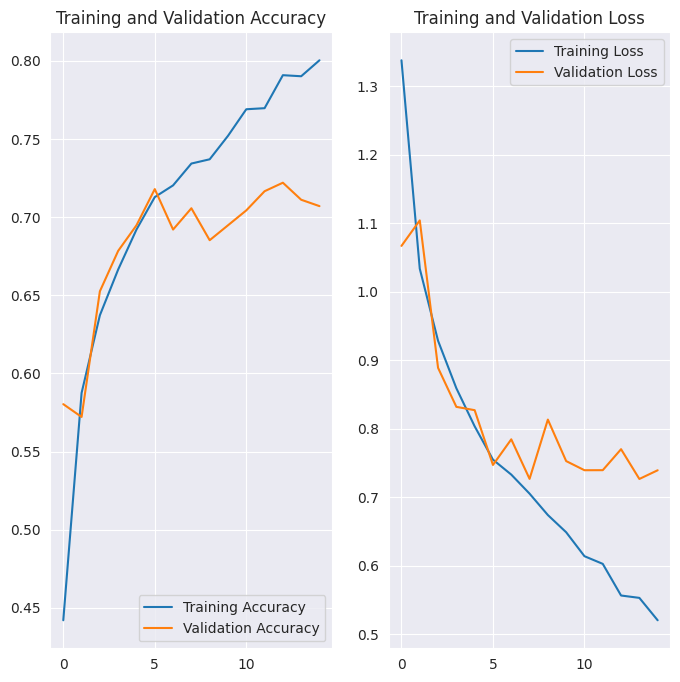

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
This image most likely belongs to sunflowers with a 91.32 percent confidence.


tf.Tensor(
[[[[151. 189. 252.]
   [154. 190. 252.]
   [154. 190. 252.]
   ...
   [ 50.  67.  49.]
   [121. 124. 129.]
   [ 24.   7.  15.]]

  [[154. 192. 255.]
   [155. 191. 253.]
   [156. 192. 254.]
   ...
   [ 35.  60.  30.]
   [ 33.  73.  49.]
   [ 30.  70.  44.]]

  [[158. 194. 255.]
   [155. 191. 253.]
   [158. 192. 253.]
   ...
   [ 43.  53.  26.]
   [ 39.  62.  36.]
   [ 35.  57.  34.]]

  ...

  [[124. 166.  54.]
   [123. 164.  60.]
   [173. 209. 113.]
   ...
   [ 47.  61.  48.]
   [ 36.  50.  24.]
   [ 71.  86.  43.]]

  [[169. 219.  98.]
   [129. 176.  64.]
   [116. 160.  49.]
   ...
   [ 50.  63.  46.]
   [ 36.  51.  32.]
   [ 38.  57.  38.]]

  [[112. 168.  33.]
   [125. 176.  55.]
   [114. 162.  44.]
   ...
   [ 43.  56.  36.]
   [ 41.  55.  32.]
   [ 42.  56.  41.]]]], shape=(1, 180, 180, 3), dtype=float32)
